In [34]:

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

retest = Subset(trainset, range(10000))
retest_loader = torch.utils.data.DataLoader(retest, batch_size=batch_size, shuffle=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


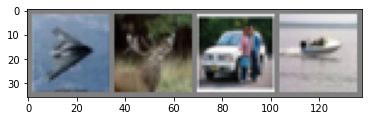

plane  deer   car  ship


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [41]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3,3), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), padding=(1,1))
        self.conv4 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=(1,1))
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(in_features=8*8*256, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.Dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #32*32*48
        x = F.relu(self.conv2(x)) #32*32*96
        x = self.pool(x) #16*16*96
        x = self.Dropout(x)
        x = F.relu(self.conv3(x)) #16*16*192
        x = F.relu(self.conv4(x)) #16*16*256
        x = self.pool(x) # 8*8*256
        x = self.Dropout(x)
        x = x.view(-1, 8*8*256) # reshape x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.Dropout(x)
        x = self.fc3(x)
        return x


net = ConvNet().to("cuda")

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [43]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    accuracy = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to("cuda"), data[1].to("cuda")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        accuracy += float(labels.eq(outputs.detach().argmax(dim=1)).float().mean())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000, accuracy*100/2000))
            running_loss = 0.0
            accuracy = 0

print('Finished Training')

[1,  2000] loss: 2.232, accuracy: 15.925
[1,  4000] loss: 1.984, accuracy: 26.512
[1,  6000] loss: 1.805, accuracy: 34.288
[1,  8000] loss: 1.635, accuracy: 40.413
[1, 10000] loss: 1.530, accuracy: 43.888
[1, 12000] loss: 1.440, accuracy: 47.987
[2,  2000] loss: 1.353, accuracy: 51.400
[2,  4000] loss: 1.270, accuracy: 54.438
[2,  6000] loss: 1.205, accuracy: 57.763
[2,  8000] loss: 1.142, accuracy: 59.237
[2, 10000] loss: 1.112, accuracy: 60.288
[2, 12000] loss: 1.065, accuracy: 62.312
[3,  2000] loss: 0.959, accuracy: 66.500
[3,  4000] loss: 0.929, accuracy: 67.338
[3,  6000] loss: 0.913, accuracy: 68.938
[3,  8000] loss: 0.883, accuracy: 69.125
[3, 10000] loss: 0.854, accuracy: 70.862
[3, 12000] loss: 0.849, accuracy: 70.537
[4,  2000] loss: 0.707, accuracy: 75.675
[4,  4000] loss: 0.714, accuracy: 75.525
[4,  6000] loss: 0.711, accuracy: 75.875
[4,  8000] loss: 0.700, accuracy: 75.388
[4, 10000] loss: 0.686, accuracy: 77.213
[4, 12000] loss: 0.685, accuracy: 76.575
Finished Trainin

In [28]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

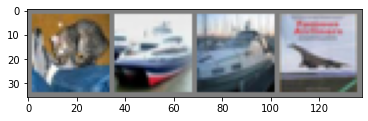

GroundTruth:    cat  ship  ship plane


In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [30]:
net = ConvNet()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

In [31]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:    cat  ship  ship  ship


In [45]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to("cuda"), data[1].to("cuda")
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in retest_loader:
        images, labels = data[0].to("cuda"), data[1].to("cuda")
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on 10000 random training images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 74 %
Accuracy of the network on 10000 random training images: 82 %


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 83 %
Accuracy of  bird : 27 %
Accuracy of   cat : 47 %
Accuracy of  deer : 41 %
Accuracy of   dog : 23 %
Accuracy of  frog : 56 %
Accuracy of horse : 65 %
Accuracy of  ship : 76 %
Accuracy of truck : 39 %
